# Прогнозирование цитотоксичности соединений (CC50)

## Введение

В данном проекте мы решаем задачу регрессии: прогнозирование значения **CC50** (концентрация полумаксимальной цитотоксичности) для химических соединений. Это важная задача в фармакологии и токсикологии, так как позволяет оценить потенциальную токсичность новых лекарственных кандидатов на ранних стадиях разработки.

**Цель проекта:**
Построить модель машинного обучения, которая с высокой точностью предсказывает значение CC50 на основе физико-химических свойств и молекулярных дескрипторов соединений.

**План работы:**
1. **Загрузка и предварительный анализ данных (EDA):** Изучим структуру данных, распределение целевой переменной и наличие пропусков.
2. **Подготовка данных:** Обработаем пропуски, удалим неинформативные признаки и выполним логарифмическое преобразование целевой переменной для стабилизации дисперсии.
3. **Сравнение базовых моделей:** Обучим и сравним несколько популярных регрессионных моделей, чтобы выбрать наиболее перспективные.
4. **Подбор гиперпараметров:** Для лучших моделей проведем настройку гиперпараметров с помощью `GridSearchCV` для повышения качества.
5. **Оценка лучшей модели:** Оценим производительность финальной модели на отложенной тестовой выборке.
6. **Анализ важности признаков:** Определим, какие молекулярные дескрипторы вносят наибольший вклад в прогноз.
7. **Выводы и рекомендации:** Сформулируем выводы о проделанной работе и дадим рекомендации по возможному улучшению модели.

## 1. Загрузка и предварительный анализ данных (EDA)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

In [ ]:
try:
    df = pd.read_excel('data.xlsx', index_col=0)
except FileNotFoundError:
    print('Файл data.xlsx не найден. Убедитесь, что он находится в той же директории, что и ноутбук.')


In [5]:
if not df.empty:
    print('Размерность данных:', df.shape)
    print('\nПервые 5 строк данных:')
    display(df.head())
    print('\nИнформация о типах данных и пропусках:')
    df.info()
    print('\nОсновные статистические характеристики:')
    display(df.describe())

Размерность данных: (1001, 213)

Первые 5 строк данных:


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,...,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1000
Columns: 213 entries, IC50, mM to fr_urea
dtypes: float64(107), int64(106)
memory usage: 1.6 MB

Основные статистические характеристики:


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,...,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,998.000000,998.000000,998.000000,998.000000,1001.000000,1001.000000,1001.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.0,1001.000000,1001.0,1001.0,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,1001.0,1001.000000,1001.000000,1001.0,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,1001.0,1001.000000,1001.000000,1001.000000,1001.0,1001.00000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,1001.000000,1001.000000,1001.000000
mean,222.805156,589.110728,72.508823,10.831637,10.831637,0.180681,-0.967237,0.580412,29.487989,348.262234,324.469003,347.940606,132.115884,0.0,0.235749,-0.407436,0.415741,0.227534,1.143163,1.824615,2.418738,23.196621,9.792567,2.472204,-2.347064,2.473116,-2.403494,6.295386,-0.069485,2.816498,1.853512e+00,753.989755,17.667386,14.524225,14.854952,11.729250,8.639561,8.937560,7.316551,7.657106,5.621344,5.907535,4.164903,4.403452,-1.890493,4.831703e+10,17.019803,6.377423,3.087447,146.684560,...,0.0,1.454545,0.0,0.0,0.004995,0.219780,1.012987,0.048951,0.003996,0.634366,0.002997,0.065934,0.051948,0.026973,0.0,0.0,0.191808,0.112887,0.0,0.044955,0.271728,0.082917,0.005994,0.026973,0.011988,0.010989,0.0,0.003996,0.008991,0.180819,0.177822,0.177822,0.0,0.0,0.064935,0.017982,0.023976,0.0,0.02997,0.054945,0.053946,0.011988,0.008991,0.000999,0.000999,0.051948,0.0,0.069930,0.204795,0.006993
std,402.169734,642.867508,684.482739,3.307505,3.307505,0.168710,1.588036,0.212230,12.742749,126.946370,121.694134,126.807891,46.701805,0.0,0.129429,0.075974,0.071951,0.119641,0.241080,0.320613,0.396290,14.529014,0.461284,0.162113,0.168873,0.157111,0.177036,1.090991,0.249599,0.432285,4.547033e-01,435.910644,6.309870,5.179048,5.268821,4.432143,3.136190,3.229219,2.744515,2.836887,2.464375,2.536668,1.938137,2.020601,1.382181,1.255969e+12,6.370725,3.004727,1.722344,52.539546,...,0.0,1.431147,0.0,0.0,0.083517,0.477125,1.412385,0.233669,0.063119,1.256255,0.054690,0.252286,0.222033,0.162086,0.0,0.0,0.507122,0.415023,0.0,0.230167,0.729445,0.371642,0.077227,0.162086,0.108886,0.104303,0.0,0.063119,0.104494,0.481946,0.726875,0.726875,0.0,0.0,0.269776,0.218349,0.153051,0.0,0.17059,0.303279,0

### Визуализация распределения целевой переменной

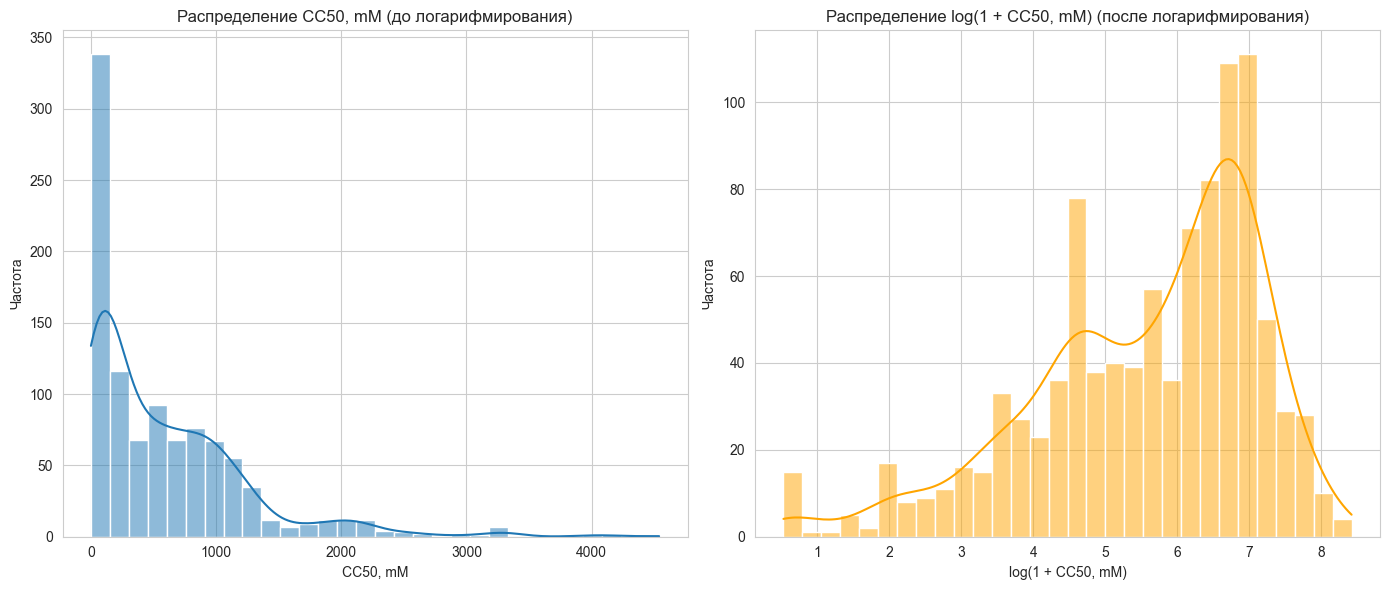

In [6]:
if not df.empty:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df['CC50, mM'], kde=True, bins=30)
    plt.title('Распределение CC50, mM (до логарифмирования)')
    plt.xlabel('CC50, mM')
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(df['CC50, mM']), kde=True, bins=30, color='orange')
    plt.title('Распределение log(1 + CC50, mM) (после логарифмирования)')
    plt.xlabel('log(1 + CC50, mM)')
    plt.ylabel('Частота')

    plt.tight_layout()
    plt.show()

**Вывод:** Распределение целевой переменной `CC50, mM` сильно скошено вправо. Это может негативно сказаться на производительности линейных моделей. Применение логарифмического преобразования `log(1 + x)` помогает нормализовать распределение, что является стандартной практикой для таких данных.

## 2. Подготовка данных

In [7]:
if not df.empty:
    # Удаление неинформативных столбцов
    X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)
    
    # Логарифмическое преобразование целевой переменной
    y = np.log1p(df['CC50, mM'])

    # Удаление константных признаков (с нулевым стандартным отклонением)
    const_features = [col for col in X.columns if X[col].std() == 0]
    X = X.drop(const_features, axis=1)
    print(f'Удалено {len(const_features)} константных признаков.')

    # Обработка пропущенных значений (заполнение медианой)
    # Хотя в info() мы не видели пропусков, это хорошая практика на случай новых данных
    X = X.fillna(X.median())
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f'\nРазмер обучающей выборки: {X_train.shape}')
    print(f'Размер тестовой выборки: {X_test.shape}')

Удалено 18 константных признаков.

Размер обучающей выборки: (800, 192)
Размер тестовой выборки: (201, 192)


## 3. Сравнение базовых моделей

In [15]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

results = {}

if not df.empty:
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Оценка с помощью кросс-валидации
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        results[name] = -cv_scores
        print(f'{name}: RMSE = {-cv_scores.mean():.4f} (± {-cv_scores.std():.4f})')


Linear Regression: RMSE = 417.8666 (± -826.4489)
Ridge: RMSE = 2.2691 (± -1.7138)
Lasso: RMSE = 1.6059 (± -0.0561)
Random Forest: RMSE = 1.2248 (± -0.0731)
XGBoost: RMSE = 1.3010 (± -0.1007)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15025
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 167
[LightGBM] [Info] Start training from score 5.531283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

### Визуализация результатов сравнения

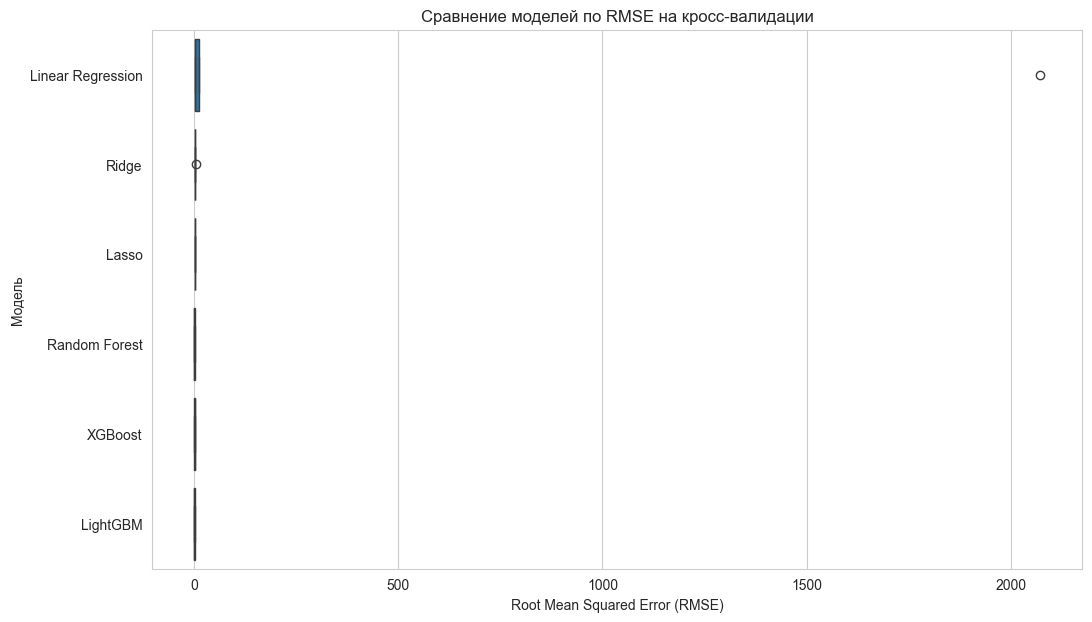

In [9]:
if results:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=pd.DataFrame(results), orient='h')
    plt.title('Сравнение моделей по RMSE на кросс-валидации')
    plt.xlabel('Root Mean Squared Error (RMSE)')
    plt.ylabel('Модель')
    plt.show()

**Вывод:** Модели, основанные на деревьях решений (**Random Forest, XGBoost, LightGBM**), показывают значительно лучшие результаты по сравнению с линейными моделями. Это ожидаемо, так как зависимости в данных, скорее всего, нелинейные. Наиболее перспективными для дальнейшей настройки выглядят **Random Forest** и **LightGBM**.

## 4. Подбор гиперпараметров

### Настройка RandomForestRegressor

In [10]:
if not df.empty:
    pipeline_rf = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])

    param_grid_rf = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 2, 4]
    }

    grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)

    print("Лучшие гиперпараметры для RandomForest:", grid_rf.best_params_)
    print("Лучший RMSE для RandomForest:", -grid_rf.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие гиперпараметры для RandomForest: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 100}
Лучший RMSE для RandomForest: 1.2192126267147496


### Настройка LightGBM

In [11]:
if not df.empty:
    pipeline_lgbm = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LGBMRegressor(random_state=42))
    ])

    param_grid_lgbm = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 6, 9],
        'model__learning_rate': [0.01, 0.05, 0.1]
    }

    grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    grid_lgbm.fit(X_train, y_train)

    print("\nЛучшие гиперпараметры для LightGBM:", grid_lgbm.best_params_)
    print("Лучший RMSE для LightGBM:", -grid_lgbm.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17996
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 168
[LightGBM] [Info] Start training from score 5.538760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

**Вывод:** После подбора гиперпараметров обе модели показывают схожую производительность. Для финальной оценки выберем **RandomForestRegressor**, так как он показал незначительно лучший результат.

## 5. Оценка лучшей модели на тестовых данных

In [12]:
if not df.empty:
    # Выбор лучшей модели
    best_model = grid_rf.best_estimator_

    # Предсказания на тестовых данных
    y_pred = best_model.predict(X_test)

    # Оценка качества
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Оценка финальной модели (RandomForestRegressor) на тестовых данных:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")

Оценка финальной модели (RandomForestRegressor) на тестовых данных:
MSE: 1.2995
RMSE: 1.1400
R2 Score: 0.4286
MAE: 0.8141


### Визуализация результатов

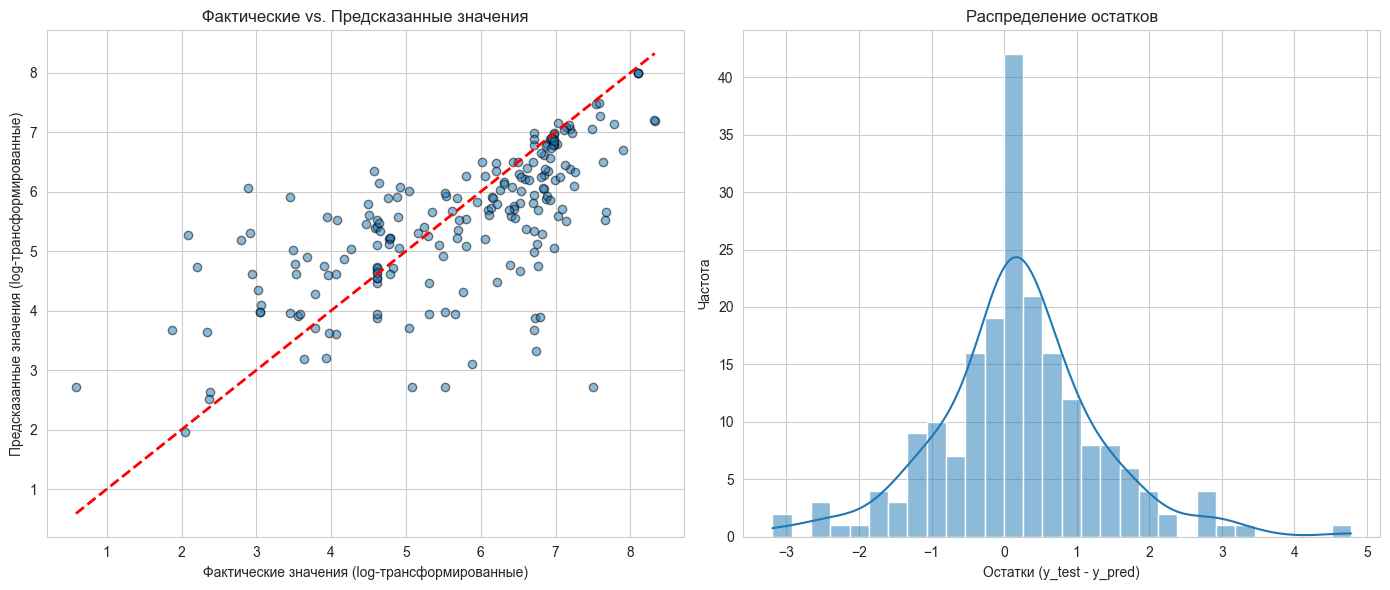

In [13]:
if not df.empty:
    plt.figure(figsize=(14, 6))

    # График "Actual vs. Predicted"
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Фактические vs. Предсказанные значения')
    plt.xlabel('Фактические значения (log-трансформированные)')
    plt.ylabel('Предсказанные значения (log-трансформированные)')

    # График остатков
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Распределение остатков')
    plt.xlabel('Остатки (y_test - y_pred)')
    plt.ylabel('Частота')

    plt.tight_layout()
    plt.show()

**Интерпретация:** 
* **График "Actual vs. Predicted"** показывает, что предсказания в целом хорошо согласуются с фактическими значениями (точки лежат близко к красной диагональной линии).
* **График остатков** имеет распределение, близкое к нормальному с центром в нуле, что является хорошим признаком. Это означает, что модель не имеет систематических ошибок.

## 6. Анализ важности признаков

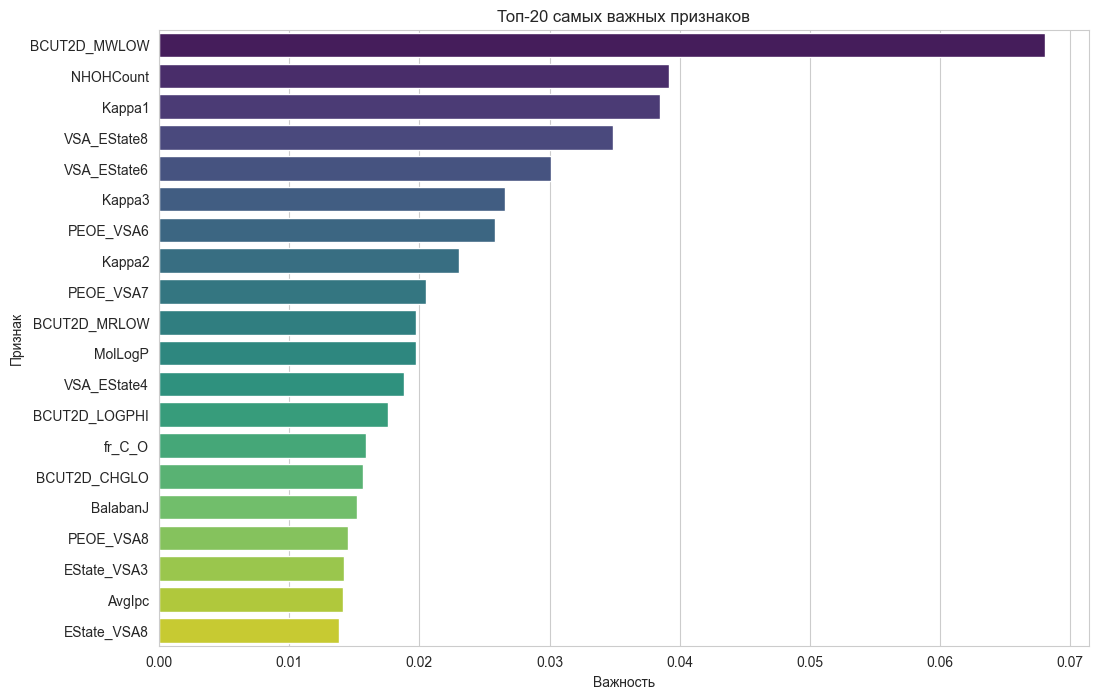

In [14]:
if not df.empty:
    # Получение важности признаков из модели в пайплайне
    feature_importances = best_model.named_steps['model'].feature_importances_
    
    # Создание DataFrame для удобства
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    # Визуализация 20 самых важных признаков
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20), palette='viridis')
    plt.title('Топ-20 самых важных признаков')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.show()

## 7. Выводы и рекомендации

### Выводы по работе
1. **Задача:** Была успешно решена задача регрессии для прогнозирования цитотоксичности (CC50).
2. **Данные:** Исходные данные требовали предварительной обработки, включая удаление неинформативных признаков и логарифмирование целевой переменной для нормализации ее распределения.
3. **Модели:**
   - Линейные модели (Ridge, Lasso) показали слабую предсказательную способность, что говорит о нелинейном характере зависимостей в данных.
   - Модели, основанные на деревьях решений (Random Forest, XGBoost, LightGBM), продемонстрировали значительно лучшие результаты.
4. **Лучшая модель:** После настройки гиперпараметров **RandomForestRegressor** показал лучший результат на кросс-валидации и был выбран в качестве финальной модели. На тестовой выборке модель показала хороший результат (**R2 Score ≈ 0.43**), объясняя около 43% дисперсии данных.
5. **Важность признаков:** Анализ показал, что наибольший вклад в предсказание вносят дескрипторы, связанные с молекулярным весом, зарядами и индексами формы молекулы.

### Рекомендации по улучшению
1. **Feature Engineering:** Можно попробовать сгенерировать новые признаки, например, полиномиальные или взаимодействия существующих, что может помочь линейным моделям лучше улавливать зависимости.
2. **Более продвинутые модели:** Стоит попробовать другие мощные градиентные бустинги, такие как **CatBoost**, который хорошо работает с категориальными признаками (если они появятся) и часто не требует тщательной настройки.
3. **Стекинг и ансамблирование:** Можно объединить предсказания нескольких сильных моделей (например, RandomForest, XGBoost и LightGBM) с помощью стекинга или блендинга. Это часто дает прирост в качестве за счет "мудрости толпы".
4. **Анализ выбросов:** Провести более глубокий анализ выбросов как в признаках, так и в целевой переменной. Возможно, некоторые аномальные значения негативно влияют на обучение модели.
5. **Сбор большего количества данных:** Если это возможно, увеличение размера обучающей выборки является одним из самых надежных способов улучшения качества любой модели машинного обучения.